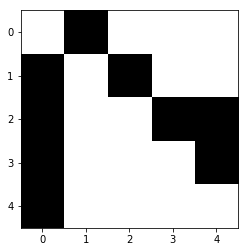

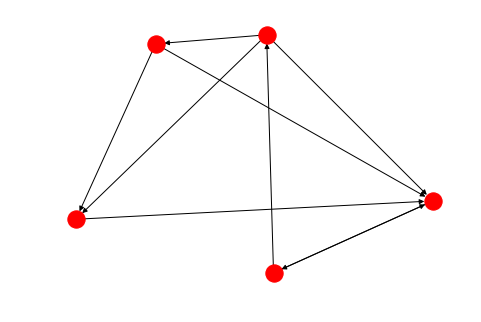

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


def plot_graph(graph):
    plt.imshow(-nx.to_numpy_array(graph), cmap='gray')
    plt.show()
    plt.clf()
    nx.draw(graph)


graph_a = nx.DiGraph(np.array([
    [0, 1, 0, 0, 0],
    [1, 0, 1, 0, 0],
    [1, 0, 0, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 0, 0, 0, 0],
]))
    
plot_graph(graph_a)

In [2]:
L_a = nx.directed_laplacian_matrix(graph_a)

print(L_a)

[[ 1.         -0.75       -0.11785113 -0.10206207 -0.25      ]
 [-0.75        1.         -0.35355339  0.          0.        ]
 [-0.11785113 -0.35355339  1.         -0.28867513 -0.23570226]
 [-0.10206207  0.         -0.28867513  1.         -0.20412415]
 [-0.25        0.         -0.23570226 -0.20412415  1.        ]]


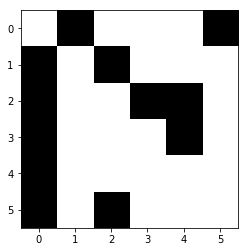

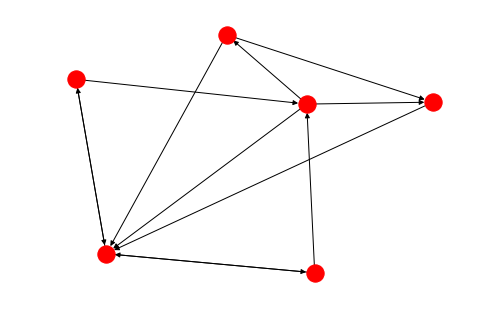

In [3]:
graph_b = nx.DiGraph(np.array([
    [0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 1, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
]))

plot_graph(graph_b)

L_b = nx.directed_laplacian_matrix(graph_b)

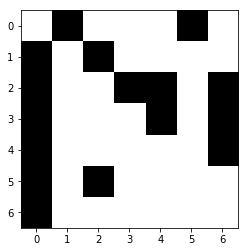

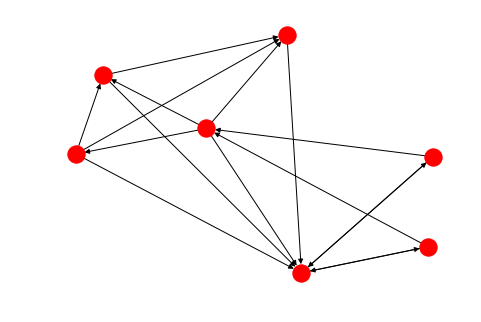

In [4]:
graph_c = nx.DiGraph(np.array([
    [0, 1, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0],
]))

plot_graph(graph_c)

L_c = nx.directed_laplacian_matrix(graph_c)

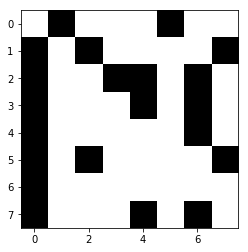

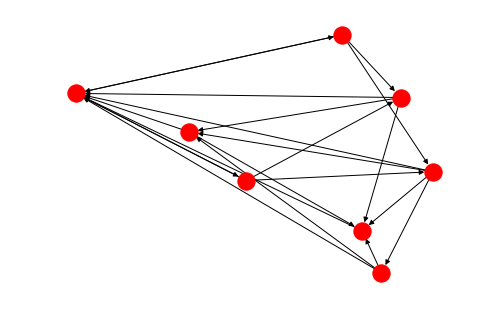

In [5]:
graph_d = nx.DiGraph(np.array([
    [0, 1, 0, 0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 1],
    [1, 0, 0, 1, 1, 0, 1, 0],
    [1, 0, 0, 0, 1, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 1, 0],
]))

plot_graph(graph_d)

L_d = nx.directed_laplacian_matrix(graph_d)

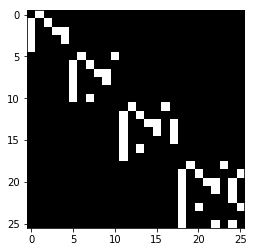

In [6]:
import scipy.sparse as sp
from scipy.linalg import block_diag



adj = block_diag(*map(nx.to_numpy_array, [graph_a, graph_b, graph_c, graph_d]))
features = sp.identity(adj.shape[0])  # featureless

plt.imshow(adj, cmap='gray');


# TODO: convert to sparce more elegantly
adj = nx.adjacency_matrix(nx.DiGraph(adj))

In [7]:
from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [8]:
adj_norm = preprocess_graph(adj)

In [9]:
import tensorflow as tf


placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [10]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# NOTE: solution to TF1.5 fuckup:
tf.app.flags.DEFINE_string('f', '', 'kernel')
# See: https://github.com/tensorflow/tensorflow/issues/17702

flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

In [11]:
num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

model = GCNModelAE(placeholders, num_features, features_nonzero)

In [12]:
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [13]:
with tf.name_scope('optimizer'):
    opt = OptimizerAE(preds=model.reconstructions,
                      labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                  validate_indices=False), [-1]),
                      pos_weight=pos_weight,
                      norm=norm)

In [14]:
# Copy-pasted from gae.train because I wanted to avoid declaring FLAGS twice
# TODO: create a utils file

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [15]:
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()


adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

In [16]:
import time


sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []

cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))


('Epoch:', '0001', 'train_loss=', '0.79807', 'train_acc=', '0.29586', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.08263')
('Epoch:', '0002', 'train_loss=', '0.78978', 'train_acc=', '0.36686', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00493')
('Epoch:', '0003', 'train_loss=', '0.77919', 'train_acc=', '0.43491', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00402')
('Epoch:', '0004', 'train_loss=', '0.76630', 'train_acc=', '0.49704', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00416')
('Epoch:', '0005', 'train_loss=', '0.75117', 'train_acc=', '0.52663', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00405')
('Epoch:', '0006', 'train_loss=', '0.73383', 'train_acc=', '0.54142', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00396')
('Epoch:', '0007', 'train_loss=', '0.71486', 'train_acc=', '0.56509', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.01690')
('Epoch:', '0008', 'train_loss=', '0.69538', 'train_acc

('Epoch:', '0102', 'train_loss=', '0.43270', 'train_acc=', '0.86095', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00428')
('Epoch:', '0103', 'train_loss=', '0.43216', 'train_acc=', '0.86095', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00346')
('Epoch:', '0104', 'train_loss=', '0.43161', 'train_acc=', '0.86095', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00399')
('Epoch:', '0105', 'train_loss=', '0.43107', 'train_acc=', '0.86095', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00362')
('Epoch:', '0106', 'train_loss=', '0.43053', 'train_acc=', '0.86095', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00366')
('Epoch:', '0107', 'train_loss=', '0.43000', 'train_acc=', '0.86095', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00341')
('Epoch:', '0108', 'train_loss=', '0.42946', 'train_acc=', '0.86095', 'val_roc=', '0.00000', 'val_ap=', '0.50000', 'time=', '0.00435')
('Epoch:', '0109', 'train_loss=', '0.42892', 'train_acc

In [21]:
feed_dict.update({placeholders['dropout']: 0})
embeddings = sess.run(model.z_mean, feed_dict=feed_dict)

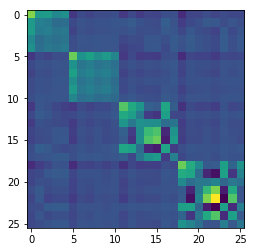

In [22]:
cossims_mat = embeddings.dot(embeddings.T)

plt.imshow(cossims_mat)